<a href="https://colab.research.google.com/github/yuxizhe/HTML-COCO-datasets-generate/blob/master/detectron2_html.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
# download, decompress the data
!wget https://github.com/yuxizhe/HTML-COCO-datasets-generate/raw/master/pic.zip
!unzip pic.zip > /dev/null

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "pic/train.json", "pic")
register_coco_instances("my_dataset_test", {}, "pic/test.json", "pic")
#register_coco_instances("my_dataset_val", {}, "validation/annotation.json", "validation")

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
train_metadata = MetadataCatalog.get("my_dataset_train")

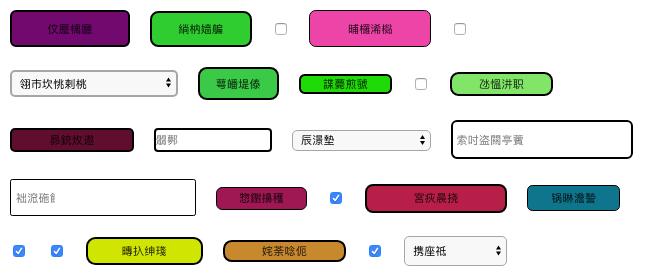

{'instances': Instances(num_instances=25, image_height=276, image_width=650, fields=[pred_boxes: Boxes(tensor([[146.8825,  11.0222, 250.3317,  46.6487],
        [196.6315,  67.2830, 277.3661,  99.9072],
        [446.9802,  71.6502, 551.4985,  95.4478],
        [ 83.6017, 236.6727, 200.0581, 264.3735],
        [296.4048,  73.3585, 391.2917,  93.3001],
        [213.1781, 187.0798, 306.2984, 210.1427],
        [360.7768, 183.2005, 501.6800, 212.6428],
        [523.9431, 184.8708, 619.5337, 211.4343],
        [305.5704,  10.5639, 428.6467,  46.7469],
        [  6.3761,   9.8524, 127.9951,  47.3033],
        [218.5026, 240.0330, 343.9868, 261.5016],
        [ 10.4404, 178.6623, 195.9603, 216.1991],
        [  6.5743, 127.9285, 131.8391, 151.6116],
        [ 50.6939, 244.9494,  63.6827, 257.2207],
        [ 12.7915, 244.8724,  25.1512, 257.0892],
        [369.3932, 244.9078, 381.4293, 257.4085],
        [454.3432,  22.7754, 465.9194,  34.6269],
        [275.5866,  23.3092, 286.9172,  34.6054

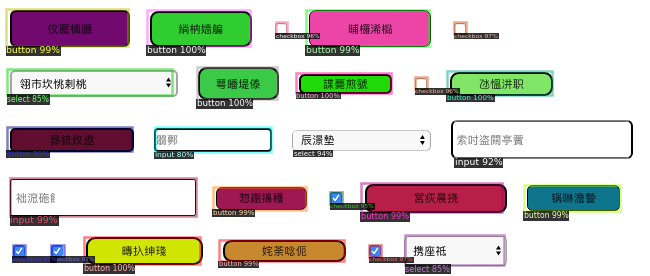

In [8]:
from detectron2.utils.visualizer import ColorMode  
im = cv2.imread("/content/pic/2020-04-19T15:00:55.339Z.png")
cv2_imshow(im)
outputs = predictor(im)
print(outputs)
v = Visualizer(im[:, :, ::-1],
                metadata=train_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])